c:\Users\Arnav Dham\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:54:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.47791
[1]	validation_0-logloss:0.36637
[2]	validation_0-logloss:0.28517
[3]	validation_0-logloss:0.22603
[4]	validation_0-logloss:0.18157
[5]	validation_0-logloss:0.14755
[6]	validation_0-logloss:0.12065
[7]	validation_0-logloss:0.10002
[8]	validation_0-logloss:0.08348
[9]	validation_0-logloss:0.07157
[10]	validation_0-logloss:0.06067
[11]	validation_0-logloss:0.05180
[12]	validation_0-logloss:0.04467
[13]	validation_0-logloss:0.03946
[14]	validation_0-logloss:0.03408
[15]	validation_0-logloss:0.03014
[16]	validation_0-logloss:0.02696
[17]	validation_0-logloss:0.02422
[18]	validation_0-logloss:0.02203
[19]	validation_0-logloss:0.01857
[20]	validation_0-logloss:0.01665
[21]	validation_0-logloss:0.01529
[22]	validation_0-logloss:0.01393
[23]	validation_0-logloss:0.01231
[24]	validation_0-logloss:0.01156
[25]	validation_0-logloss:0.01084
[26]	validation_0-logloss:0.00996
[27]	validation_0-logloss:0.00936
[28]	validation_0-logloss:0.00877
[29]	validation_0-loglos

c:\Users\Arnav Dham\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:54:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[43]	validation_0-logloss:0.00509
[44]	validation_0-logloss:0.00496
[45]	validation_0-logloss:0.00488
[46]	validation_0-logloss:0.00484
[47]	validation_0-logloss:0.00475
[48]	validation_0-logloss:0.00460
[49]	validation_0-logloss:0.00453
[50]	validation_0-logloss:0.00448
[51]	validation_0-logloss:0.00438
[52]	validation_0-logloss:0.00432
[53]	validation_0-logloss:0.00426
[54]	validation_0-logloss:0.00415
[55]	validation_0-logloss:0.00408
[56]	validation_0-logloss:0.00400
[57]	validation_0-logloss:0.00393
[58]	validation_0-logloss:0.00385
[59]	validation_0-logloss:0.00377
[60]	validation_0-logloss:0.00363
[61]	validation_0-logloss:0.00356
[62]	validation_0-logloss:0.00351
[63]	validation_0-logloss:0.00346
[64]	validation_0-logloss:0.00339
[65]	validation_0-logloss:0.00337
[66]	validation_0-logloss:0.00335
[67]	validation_0-logloss:0.00333
[68]	validation_0-logloss:0.00327
[69]	validation_0-logloss:0.00317
[70]	validation_0-logloss:0.00315
[71]	validation_0-logloss:0.00312
[72]	validatio

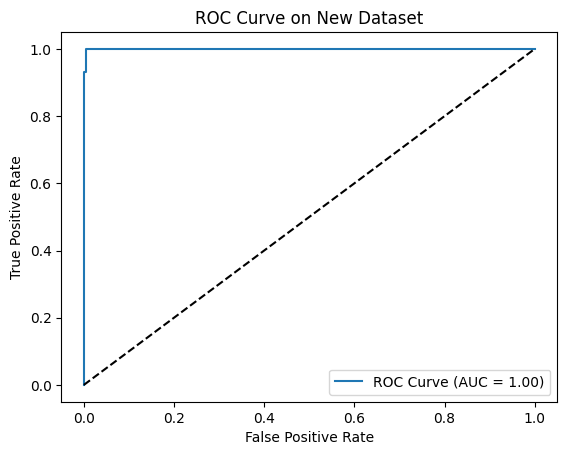

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load datasets
df_train = pd.read_csv(r"C:\Users\Arnav Dham\OneDrive\Desktop\SOP\Dataset\Syn-training.csv")
df_test = pd.read_csv(r"C:\Users\Arnav Dham\OneDrive\Desktop\SOP\Dataset\Syn-testing.csv")  

# Combine for feature selection (80% train, 20% test)
df_combined = pd.concat([df_train, df_test.sample(frac=0.2, random_state=42)])
X_combined = df_combined.drop("Label", axis=1)
y_combined = LabelEncoder().fit_transform(df_combined["Label"])  # Benign=0, Syn=1

# Feature selection on combined data
initial_xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
initial_xgb.fit(X_combined, y_combined)
feature_importance = initial_xgb.get_booster().get_score(importance_type="weight")
selected_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:15]  # Top 15
selected_features = [f[0] for f in selected_features]

# Prepare training and test sets
X_train = df_train[selected_features]
y_train = LabelEncoder().fit_transform(df_train["Label"])
X_test = df_test[selected_features]
y_test = LabelEncoder().fit_transform(df_test["Label"])

# Split training for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Train with SYN priority
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=1.6,  # Prioritize SYN (8661 SYN / 5407 Benign)
    max_depth=3,
    learning_rate=0.2,
    n_estimators=100,  #Reduced to avoid overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=2.0  # L2 regularization
)

model.fit(X_train_split, y_train_split, eval_set=[(X_val, y_val)], verbose=True)

# Predict on test set
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_default = model.predict(X_test)

# Evaluate default threshold
print("Default Threshold (0.5):")
print("Accuracy:", (y_pred_default == y_test).mean())
print("Classification Report:\n", classification_report(y_test, y_pred_default))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_default))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

# Tune threshold for higher SYN recall
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for thresh in thresholds:
    y_pred = (y_pred_proba >= thresh).astype(int)
    acc = (y_pred == y_test).mean()
    recall_syn = classification_report(y_test, y_pred, output_dict=True)["1"]["recall"]
    print(f"Threshold {thresh}: Accuracy={acc:.4f}, SYN Recall={recall_syn:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on New Dataset")
plt.legend()
plt.show()

c:\Users\Arnav Dham\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:02:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Arnav Dham\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:02:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Results on syn-testing.csv (Third Dataset):
Accuracy: 0.9977949283351709
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       374
           1       1.00      1.00      1.00       533

    accuracy                           1.00       907
   macro avg       1.00      1.00      1.00       907
weighted avg       1.00      1.00      1.00       907

Confusion Matrix:
 [[372   2]
 [  0 533]]
ROC-AUC: 0.9999999999999999
Threshold 0.1: Accuracy=0.9912, SYN Recall=1.0000
Threshold 0.2: Accuracy=0.9967, SYN Recall=1.0000
Threshold 0.3: Accuracy=0.9978, SYN Recall=1.0000
Threshold 0.4: Accuracy=0.9978, SYN Recall=1.0000
Threshold 0.5: Accuracy=0.9978, SYN Recall=1.0000


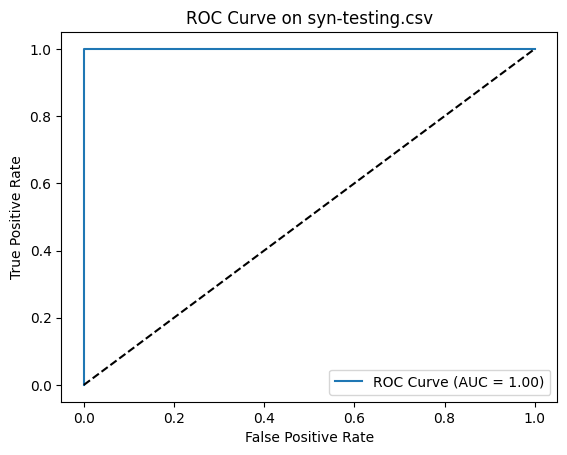

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the original training dataset for feature selection and training
df_train = pd.read_csv(r"C:\Users\Arnav Dham\OneDrive\Desktop\SOP\Dataset\Syn-training.csv")
df_test = pd.read_csv(r"C:\Users\Arnav Dham\OneDrive\Desktop\SOP\Dataset\syn-testing.csv")  

# Combine 100% train + 20% of the second dataset for feature selection (as before)
df_combined = pd.concat([df_train, df_test.sample(frac=0.2, random_state=42)])
X_combined = df_combined.drop("Label", axis=1)
y_combined = LabelEncoder().fit_transform(df_combined["Label"])  # Benign=0, Syn=1

# Feature selection on combined data
initial_xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
initial_xgb.fit(X_combined, y_combined)
feature_importance = initial_xgb.get_booster().get_score(importance_type="weight")
selected_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:15]  # Top 15
selected_features = [f[0] for f in selected_features]

# Prepare training data with selected features
X_train = df_train[selected_features]
y_train = LabelEncoder().fit_transform(df_train["Label"])

# Train the model (same parameters as before)
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=1.6,  # Prioritize SYN
    max_depth=3,
    learning_rate=0.2,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=2.0
)
model.fit(X_train, y_train, verbose=True)

# Load the third dataset (syn-testing)
df_syn_testing = pd.read_csv(r"C:\Users\Arnav Dham\OneDrive\Desktop\SOP\Dataset\syn-testing.csv")  # Adjust path as needed

# Prepare syn-testing data with the same selected features
X_syn_testing = df_syn_testing[selected_features]
y_syn_testing = LabelEncoder().fit_transform(df_syn_testing["Label"])  # Benign=0, Syn=1

# Predict on syn-testing
y_pred_proba = model.predict_proba(X_syn_testing)[:, 1]
y_pred_default = model.predict(X_syn_testing)

# Evaluate on syn-testing
print("Results on syn-testing.csv (Third Dataset):")
print("Accuracy:", (y_pred_default == y_syn_testing).mean())
print("Classification Report:\n", classification_report(y_syn_testing, y_pred_default))
print("Confusion Matrix:\n", confusion_matrix(y_syn_testing, y_pred_default))
print("ROC-AUC:", roc_auc_score(y_syn_testing, y_pred_proba))

# Tune threshold for higher SYN recall
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for thresh in thresholds:
    y_pred_adjusted = (y_pred_proba >= thresh).astype(int)
    acc = (y_pred_adjusted == y_syn_testing).mean()
    recall_syn = classification_report(y_syn_testing, y_pred_adjusted, output_dict=True)["1"]["recall"]
    print(f"Threshold {thresh}: Accuracy={acc:.4f}, SYN Recall={recall_syn:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_syn_testing, y_pred_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_syn_testing, y_pred_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on syn-testing.csv")
plt.legend()
plt.show()

c:\Users\Arnav Dham\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Arnav Dham\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:36:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Results on syn-testing.csv (Third Dataset - 80% of df_test):
Accuracy: 0.9972451790633609
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       302
           1       1.00      1.00      1.00       424

    accuracy                           1.00       726
   macro avg       1.00      1.00      1.00       726
weighted avg       1.00      1.00      1.00       726

Confusion Matrix:
 [[300   2]
 [  0 424]]
ROC-AUC: 1.0
Threshold 0.1: Accuracy=0.9917, SYN Recall=1.0000
Threshold 0.2: Accuracy=0.9959, SYN Recall=1.0000
Threshold 0.3: Accuracy=0.9972, SYN Recall=1.0000
Threshold 0.4: Accuracy=0.9972, SYN Recall=1.0000
Threshold 0.5: Accuracy=0.9972, SYN Recall=1.0000


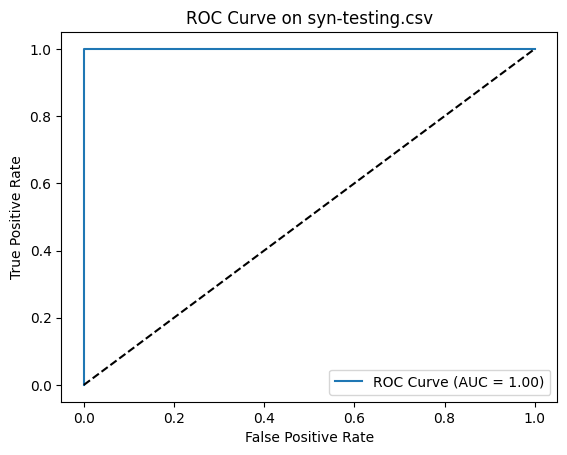

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the original training dataset
df_train = pd.read_csv(r"C:\Users\Arnav Dham\OneDrive\Desktop\SOP\Dataset\Syn-training.csv")
df_test = pd.read_csv(r"C:\Users\Arnav Dham\OneDrive\Desktop\SOP\Dataset\syn-testing.csv")  

# Split df_test: 20% for feature selection, 80% for final testing
df_test_sampled = df_test.sample(frac=0.2, random_state=42)  # 20% used for feature selection
df_syn_testing = df_test.drop(df_test_sampled.index)  # 80% reserved for final evaluation

# Combine df_train + 20% of df_test for feature selection
df_combined = pd.concat([df_train, df_test_sampled])
X_combined = df_combined.drop("Label", axis=1)
y_combined = LabelEncoder().fit_transform(df_combined["Label"])  # Benign=0, Syn=1

# Feature selection on combined data
initial_xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
initial_xgb.fit(X_combined, y_combined)
feature_importance = initial_xgb.get_booster().get_score(importance_type="weight")
selected_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:15]  # Top 15
selected_features = [f[0] for f in selected_features]

# Prepare training data with selected features
X_train = df_train[selected_features]
y_train = LabelEncoder().fit_transform(df_train["Label"])

# Train the model
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=1.6,  # Prioritize SYN
    max_depth=3,
    learning_rate=0.2,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1, 
    reg_lambda=2.0 #reduce overfitting
)
model.fit(X_train, y_train, verbose=True)

# Prepare syn-testing data (80% of df_test) with the same selected features
X_syn_testing = df_syn_testing[selected_features]
y_syn_testing = LabelEncoder().fit_transform(df_syn_testing["Label"])  # Benign=0, Syn=1

# Predict on syn-testing
y_pred_proba = model.predict_proba(X_syn_testing)[:, 1]
y_pred_default = model.predict(X_syn_testing)

# Evaluate on syn-testing
print("Results on syn-testing.csv (Third Dataset - 80% of df_test):")
print("Accuracy:", (y_pred_default == y_syn_testing).mean())
print("Classification Report:\n", classification_report(y_syn_testing, y_pred_default))
print("Confusion Matrix:\n", confusion_matrix(y_syn_testing, y_pred_default))
print("ROC-AUC:", roc_auc_score(y_syn_testing, y_pred_proba))

# Tune threshold for higher SYN recall
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for thresh in thresholds:
    y_pred_adjusted = (y_pred_proba >= thresh).astype(int)
    acc = (y_pred_adjusted == y_syn_testing).mean()
    recall_syn = classification_report(y_syn_testing, y_pred_adjusted, output_dict=True)["1"]["recall"]
    print(f"Threshold {thresh}: Accuracy={acc:.4f}, SYN Recall={recall_syn:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_syn_testing, y_pred_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_syn_testing, y_pred_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on syn-testing.csv")
plt.legend()
plt.show()


c:\Users\Arnav Dham\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:20:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Arnav Dham\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:20:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Results on syn-testing.csv
Accuracy: 0.9977949283351709
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       374
           1       1.00      1.00      1.00       533

    accuracy                           1.00       907
   macro avg       1.00      1.00      1.00       907
weighted avg       1.00      1.00      1.00       907

Confusion Matrix:
 [[372   2]
 [  0 533]]
ROC-AUC: 0.9985753127790431
Threshold 0.1: Accuracy=0.9868, SYN Recall=1.0000
Threshold 0.2: Accuracy=0.9923, SYN Recall=1.0000
Threshold 0.3: Accuracy=0.9978, SYN Recall=1.0000
Threshold 0.4: Accuracy=0.9978, SYN Recall=1.0000
Threshold 0.5: Accuracy=0.9978, SYN Recall=1.0000


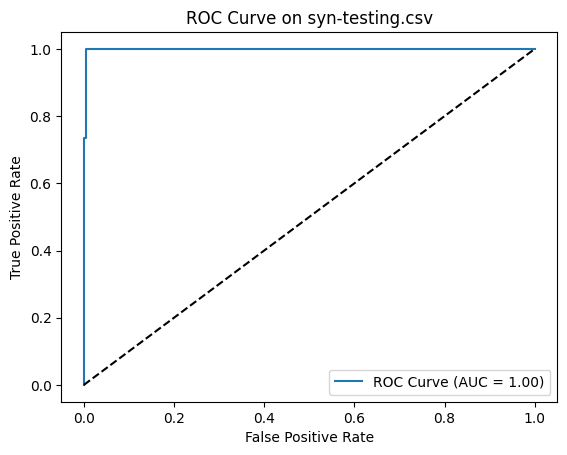

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the original training dataset for feature selection and training
df_train = pd.read_csv(r"C:\Users\Arnav Dham\OneDrive\Desktop\SOP\Dataset\Syn-training.csv") 

X_combined = df_train.drop("Label", axis=1)
y_combined = LabelEncoder().fit_transform(df_train["Label"])  # Benign=0, Syn=1

# Feature selection on combined data
initial_xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
initial_xgb.fit(X_combined, y_combined)
feature_importance = initial_xgb.get_booster().get_score(importance_type="weight")
selected_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:15]  # Top 15
selected_features = [f[0] for f in selected_features]

# Prepare training data with selected features
X_train = df_train[selected_features]
y_train = LabelEncoder().fit_transform(df_train["Label"])

# Train the model
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=1.6,  # Prioritize SYN
    max_depth=3,
    learning_rate=0.2,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1, #reduce parameters
    reg_lambda=2.0 #reduce overfitting 
)
model.fit(X_train, y_train, verbose=True)

df_syn_testing = pd.read_csv(r"C:\Users\Arnav Dham\OneDrive\Desktop\SOP\Dataset\syn-testing.csv")  # Adjust path as needed

# Prepare syn-testing data with the same selected features
X_syn_testing = df_syn_testing[selected_features]
y_syn_testing = LabelEncoder().fit_transform(df_syn_testing["Label"])  # Benign=0, Syn=1

# Predict on syn-testing
y_pred_proba = model.predict_proba(X_syn_testing)[:, 1]
y_pred_default = model.predict(X_syn_testing)

# Evaluate on syn-testing
print("Results on syn-testing.csv")
print("Accuracy:", (y_pred_default == y_syn_testing).mean())
print("Classification Report:\n", classification_report(y_syn_testing, y_pred_default))
print("Confusion Matrix:\n", confusion_matrix(y_syn_testing, y_pred_default))
print("ROC-AUC:", roc_auc_score(y_syn_testing, y_pred_proba))

# Tune threshold for higher SYN recall
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for thresh in thresholds:
    y_pred_adjusted = (y_pred_proba >= thresh).astype(int)
    acc = (y_pred_adjusted == y_syn_testing).mean()
    recall_syn = classification_report(y_syn_testing, y_pred_adjusted, output_dict=True)["1"]["recall"]
    print(f"Threshold {thresh}: Accuracy={acc:.4f}, SYN Recall={recall_syn:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_syn_testing, y_pred_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_syn_testing, y_pred_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on syn-testing.csv")
plt.legend()
plt.show()

In [3]:
selected_features





['Init Fwd Win Bytes',
 'Init Bwd Win Bytes',
 'ACK Flag Count',
 'Flow Bytes/s',
 'Bwd Packets/s',
 'Flow IAT Std',
 'Flow Duration',
 'Fwd Packets Length Total',
 'Flow IAT Max',
 'Packet Length Min',
 'SYN Flag Count',
 'Flow IAT Mean',
 'Fwd Packets/s',
 'Packet Length Std',
 'Fwd Packet Length Min']

C:\Users\Arnav Dham\AppData\Local\Temp\ipykernel_3128\4219893403.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_values, y=feature_names, palette="viridis")


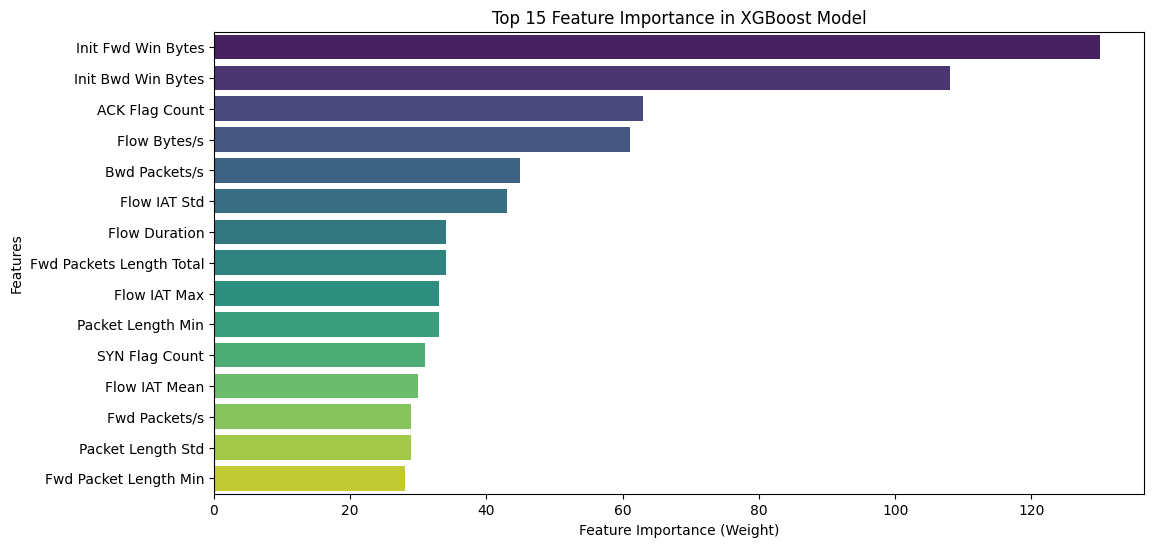

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature names and importance values correctly
selected_features_tuples = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:15]
feature_names = [f[0] for f in selected_features_tuples]
importance_values = [f[1] for f in selected_features_tuples]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_values, y=feature_names, palette="viridis")
plt.xlabel("Feature Importance (Weight)")
plt.ylabel("Features")
plt.title("Top 15 Feature Importance in XGBoost Model")
plt.show()


c:\Users\Arnav Dham\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:27:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Arnav Dham\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:27:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Results on 20% Test Split:
Accuracy: 0.9995024168325277
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5407
           1       1.00      1.00      1.00      8661

    accuracy                           1.00     14068
   macro avg       1.00      1.00      1.00     14068
weighted avg       1.00      1.00      1.00     14068

Confusion Matrix:
 [[5406    1]
 [   6 8655]]
ROC-AUC: 0.9999976724335434
Threshold 0.1: Accuracy=0.9986, SYN Recall=0.9997
Threshold 0.2: Accuracy=0.9993, SYN Recall=0.9995
Threshold 0.3: Accuracy=0.9994, SYN Recall=0.9995
Threshold 0.4: Accuracy=0.9995, SYN Recall=0.9994
Threshold 0.5: Accuracy=0.9995, SYN Recall=0.9993


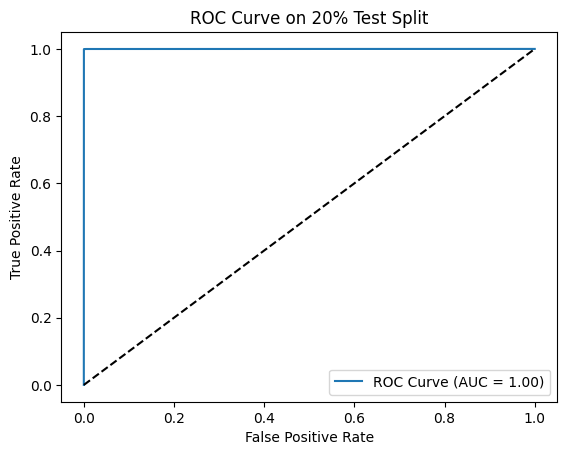

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv(r"C:\Users\Arnav Dham\OneDrive\Desktop\SOP\Dataset\Syn-training.csv")

# Split into features and labels
X = df.drop("Label", axis=1)
y = LabelEncoder().fit_transform(df["Label"])  # Benign=0, Syn=1



# Feature selection using XGBoost
initial_xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
initial_xgb.fit(X_train, y_train)
feature_importance = initial_xgb.get_booster().get_score(importance_type="weight")
selected_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:15]
selected_features = [f[0] for f in selected_features]

# Split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train the final model
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=1.6,
    max_depth=3,
    learning_rate=0.2,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=2.0
)
model.fit(X_train_selected, y_train, verbose=True)

# Predict on test set
y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
y_pred_default = model.predict(X_test_selected)

# Evaluate on test set
print("Results on 20% Test Split:")
print("Accuracy:", (y_pred_default == y_test).mean())
print("Classification Report:\n", classification_report(y_test, y_pred_default))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_default))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

# Tune threshold for higher SYN recall
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for thresh in thresholds:
    y_pred_adjusted = (y_pred_proba >= thresh).astype(int)
    acc = (y_pred_adjusted == y_test).mean()
    recall_syn = classification_report(y_test, y_pred_adjusted, output_dict=True)["1"]["recall"]
    print(f"Threshold {thresh}: Accuracy={acc:.4f}, SYN Recall={recall_syn:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on 20% Test Split")
plt.legend()
plt.show()